In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## General program

In [2]:
# %load heptools.py
#!/usr/bin/env python
#DEBUG: Fix casas_ibarra test

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
import pylab
import cmath
import math
import commands
import sys
import time
import re
import os
# %load configrun_IDM.py
def get_config(key):
    import numpy as np
    import commands
    import sys
    
    if key=='SM':
        return {'G_F': 1.166e-05, 'alpha_em': 0.0078125, 'm_e': 0.000511, \
                'm_mu': 0.1057, 'm_tau': 1.777, 'vev': 246.0, \
                'MW': 80.385, 'MZ': 91.1876, 'WH':4.21e-3,'m_pi0':134.9766E-3,\
                'm_pipm':139.57018E-3,'hbarc':1.973269631E-16,'V_ud':0.97425,\
                'f_pi':131E-3}


    
        #test constants

def Lambda(Mk,mH0,mA0):
    '''Loop funtion, defined for each neutral triplet component'''
    return (Mk/(16*pi**2))*((mH0**2/(mH0**2-Mk**2))*np.log(mH0**2/Mk**2) -(mA0**2/(mA0**2-Mk**2))*np.log(mA0**2/Mk**2)  )


def neutrino_data(CL=3,IH=False):
    import numpy as np
    '''From arxiv:1405.7540 (table I)
    and asumming a Normal Hierarchy:
    Output:
    mnu1in: laightest neutrino mass
    Dms2: \Delta m^2_{12}
    Dma2: \Delta m^2_{13}
    ThetSol,ThetAtm,ThetRec: in radians
    '''
    if CL==3:
        Dms2=np.array([7.11e-5, 7.60e-5, 8.18e-5])*1e-18 # In GeV
        Dma2=np.array([2.30e-3, 2.48e-3, 2.65e-3])*1e-18 # In GeV
        if IH:
            Dma2=np.array([2.20e-3, 2.38e-3, 2.54e-3])*1e-18 # In GeV
        #input real values:
        #
        ThetSol = np.array([0.278,  0.323,  0.375]) 
        ThetAtm = np.array([0.393,  0.567,  0.643])
        if IH:
            ThetAtm = np.array([0.403,  0.573,  0.640])
        ThetRec = np.array([0.0190, 0.0226, 0.0262])
        if IH:
            ThetRec = np.array([0.0193, 0.0229, 0.0265])
            
        delta=np.array([0,np.pi,2.*np.pi])
    elif CL==1:
        Dms2=np.array([7.11e-5, 7.60e-5, 8.18e-5])*1e-18 # In GeV
        Dma2=np.array([2.41e-3, 2.48e-3, 2.53e-3])*1e-18 # In GeV
        if IH:
            Dma2=np.array([2.32e-3, 2.38e-3, 2.43e-3])*1e-18 # In GeV
        #input real values:
        #
        ThetSol = np.array([0.307,  0.323,  0.339]) 
        ThetAtm = np.array([0.443,  0.567,  0.599])
        if IH:
            ThetAtm = np.array([0.534,  0.573,  0.598])
        ThetRec = np.array([0.0214, 0.0226, 0.0238])
        if IH:
            ThetRec = np.array([0.0217, 0.0229, 0.0241])
        delta=np.array([1.01*np.pi,1.41*np.pi,1.96*np.pi])
        if IH:
            delta=np.array([1.17*np.pi,1.48*np.pi,1.79*np.pi])
    mnu1in=1E-5*1E-9

    return mnu1in,Dms2,Dma2,ThetSol,ThetAtm,ThetRec,delta

def casasibarra(di,norotate1=False,norotate2=False,norotate3=False,bestfit=False,\
                nophases=False,massless_nulight=False,min_nulight=1E-9,max_nulight=0.5,\
                IH=False,R_complex=True,min_angle=0,CL=3):
    """
    min_nulight=1E-9,
    max_nulight=0.5 in eV: pdg neutrino review
       NH: nu1<nu2<nu3
    We assume mass ordering for Heavy particles but inverse hierarchy (IH) for neutrinos could imply:
       IH: nu3<nu1<nu2
    di.keys()-> ['MH0','MA0','Mtr01','Mtr02','Mtr03',]
    """
    import numpy as np
    import pandas as pd
    di=pd.Series(di)
    if massless_nulight:
        norotate2=True #R13=1
        if not IH:
            norotate1=True #R12=1
        else:
            norotate3=True #R23=1
        
        
    
    ignore,Dms2,Dma2,ThetSol,ThetAtm,ThetRec,deltaD=neutrino_data(CL=CL,IH=IH) 

    
    #Inverse MR masses. M^R_3 -> infty corresponds to zero entry
    Mtr01t=1./np.abs(Lambda(di.Mtr01,di.MH0,di.MA0))
    Mtr02t=1./np.abs(Lambda(di.Mtr02,di.MH0,di.MA0))
    Mtr03t=1.*( 0. if massless_nulight else 1./np.abs(Lambda(di.Mtr03,di.MH0,di.MA0)) )
    
    
    DMR=np.asarray([ [np.sqrt( Mtr01t),0,0],[0,np.sqrt(Mtr02t),0],[0,0,np.sqrt(Mtr03t)] ]   )
    
    #phases of the PMNS matrix
    
    delta=1.*(0 if nophases else np.random.uniform(deltaD[0],deltaD[2]))
    eta1 =1.*(0 if nophases else np.random.uniform(0.,np.pi)) 
    eta2 =1.*(0 if nophases else np.random.uniform(0.,np.pi))
    if bestfit:
        delta=deltaD[1]
    
    if not IH:
        mnu1=np.exp(np.random.uniform(np.log(min_nulight),np.log(max_nulight)))*1e-9 
        #m_3=m_3^2-m_1^2+m_1^2
        mnu3=1.*(np.sqrt(Dma2[1]+mnu1**2)     if bestfit else  np.sqrt(np.random.uniform(Dma2[0],Dma2[2]) + mnu1**2) )
    else:
        mnu3=np.exp(np.random.uniform(np.log(min_nulight),np.log(max_nulight)))*1e-9 
        #m_1=|m_3^2-m_1^2|+m_3^2=m_1^2-m_3^2+m_3^2=
        mnu1=1.*(np.sqrt(Dma2[1]+mnu3**2)     if bestfit else  np.sqrt(np.random.uniform(Dma2[0],Dma2[2]) + mnu3**2) )

    if massless_nulight:
        if IH:
            mnu3=0
            mnu1=1.*(np.sqrt(Dma2[1]+mnu3**2)     if bestfit else  np.sqrt(np.random.uniform(Dma2[0],Dma2[2]) + mnu3**2) )
        else:
            mnu1=0   
            mnu3=1.*(np.sqrt(Dma2[1]+mnu1**2)     if bestfit else  np.sqrt(np.random.uniform(Dma2[0],Dma2[2]) + mnu1**2) )

    #m_2=m_2^2-m_1^2+m_1^2    
    mnu2=1.*(np.sqrt(Dms2[1]+mnu1**2)     if bestfit else  np.sqrt(np.random.uniform(Dms2[0],Dms2[2]) + mnu1**2) ) 

    #light neutrino masses only for an estimation 
    #mnu1=0
    #mnu2=sqrt(8.2e-5*1e-18+mnu1**2)
    #mnu3=sqrt(2.74e-3*1e-18+mnu1**2)
    
    #Square root of left-handed nuetrino mass matrix 
    DMnu=np.asarray([ [np.sqrt(mnu1),0,0],[0,np.sqrt(mnu2),0],[0,0,np.sqrt(mnu3)] ])
    
    #mixing angles using 3 sigma data from arxiv:1405.7540 (table I)                        
    #and asumming a Normal Hierarchy'''



    t12 = 1.*( np.arcsin(np.sqrt(ThetSol[1])) if bestfit else np.arcsin(np.sqrt(np.random.uniform(ThetSol[0],ThetSol[2]))))
    t23 = 1.*( np.arcsin(np.sqrt(ThetAtm[1])) if bestfit else np.arcsin(np.sqrt(np.random.uniform(ThetAtm[0],ThetAtm[2]))))
    t13 = 1.*( np.arcsin(np.sqrt(ThetRec[1])) if bestfit else np.arcsin(np.sqrt(np.random.uniform(ThetRec[0],ThetRec[2]))))
    
    
    #Building PMNS matrix: http://pdg.lbl.gov/2014/reviews/rpp2014-rev-neutrino-mixing.pdf
    
    U12 = np.array([ [np.cos(t12),np.sin(t12),0], [-np.sin(t12),np.cos(t12),0], [0,0,1.0] ])
    U13 = np.array([ [np.cos(t13),0,np.sin(t13)*np.exp(-delta*1j)], [0,1.0,0],\
                     [-np.sin(t13)*np.exp(delta*1j),0,np.cos(t13)] ])
    U23 = np.array([ [1.0,0,0], [0,np.cos(t23),np.sin(t23)], [0,-np.sin(t23),np.cos(t23)] ])
    Uphases = np.diag([1.,np.exp(eta1*1j/2.),np.exp(eta2*1j/2.)])
    U=((U23.dot(U13)).dot(U12)).dot(Uphases)
    #print U-np.dot(U23,np.dot(U13,np.dot(U12,Uphases)))
    #Building R matrix of the Casas-Ibarra parametrization
    
    
    min_real=min_angle
    max_real=2.*np.pi
    phases2=np.random.uniform(min_real,max_real ,3) 
    if R_complex:
        min_imag=1E-12
        max_imag=20. #2E-1
        phases2=phases2+1j*np.exp(np.random.uniform(\
                            np.log(min_imag),np.log(max_imag) ,3) )*np.random.choice([1,-1])
    

    b12 = 1.*(0 if norotate1 else phases2[0])
    b13 = 1.*(0 if norotate2 else phases2[1])
    b23 = 1.*(0 if norotate3 else phases2[2])
    
  
    # R 
    R12 = array([ [np.cos(b12),np.sin(b12),0], [-np.sin(b12),np.cos(b12),0], [0,0,1.0] ])
    R13 = array([ [np.cos(b13),0,np.sin(b13)], [0,1.0,0], [-np.sin(b13),0,np.cos(b13)] ])
    R23 = array([ [1.0,0,0], [0,np.cos(b23),np.sin(b23)], [0,-np.sin(b23),np.cos(b23)] ])
    R=dot(R23,dot(R13,R12))
    #1assert(np.abs(np.dot(R, R.transpose()))[1,2]<1E-10)
    #Yukawa matrix of the Casas-Ibarra parametrization
    yuk2=dot(DMR,dot(R,dot(DMnu,transpose(conjugate(U)))))
    return yuk2,U,DMnu.dot(DMnu),phases2


def Fme(x,xmin=0.996,xmax=1.005,xfit=1.001):
    """Fixing near to one values
     xmin: close to 1 from below
     xmax: close to 1 from above
     xfit:  optimized 1 limit
    """
    x=np.asarray(x)
    if x.shape:
        x[np.logical_and(x>xmin,x<xmax)]=xfit
    else:
        if x>xmin and x<xmax:
            x=xfit
        
    return (1.-6.*x+3.*x**2+2.*x**3-6*x**2*np.log(x))/(6.*(x-1.)**4)

def LFV(SM,dp,yuk):
    '''Oscar Notes with \pi^2 -> \pi
    '''
    import numpy as np
    const=False
    SM=pd.Series(SM)
    y=np.matrix(yuk)
    
    dp=pd.Series(dp)
    FMl=[]
    for i in range(1,4):
        dp['Mtrp%d' %i]=dp['Mtr0%d' %i] #degenerate fermions
        FMl.append(1./(dp.MHC**2)*Fme(dp['Mtr0%d' %i]**2/dp.MHC**2)\
                   -1./(dp['Mtr0%d' %i]**2)*( Fme(dp.MH0**2/dp['Mtrp%d' %i]**2)\
                                            + Fme(dp.MA0**2/dp['Mtrp%d' %i]**2)   )  )
    FM=np.matrix(np.diag(FMl))
    
    Brmueg  =(3.*SM.alpha_em/(4.*16.*np.pi*SM.G_F**2)*np.abs(y[:,0].T*FM*y[:,1].conjugate())**2)[0,0]
    Brtaumug=(3.*SM.alpha_em/(4.*16.*np.pi*SM.G_F**2)*np.abs(y[:,1].T*FM*y[:,2].conjugate())**2)[0,0]
    if (Brmueg<5.7e-13):
       if (Brtaumug<4.5e-8):
           const=True

    return Brmueg,Brtaumug,const
        




In [3]:
import datetime

## Main program

In [4]:
def Ynorm(dp,norotate1=False,norotate2=False,norotate3=False,bestfit=False,nophases=False,\
             massless_nulight=False,min_nulight=1E-9,max_nulight=0.5,IH=False,R_complex=True,\
             min_angle=1E-12,CL=3):
    '''IH: Inverse Hierarchy
    \Sum_m_nu<0.15 see: http://resonaances.blogspot.com/2014/12/planck-whats-new.html
    '''
    DEBUG=False
    import pandas as pd
    dp=pd.Series(dp)
    x=pd.Series()
    yuk,U,Mnu,phases = casasibarra(dp,norotate1=norotate1,norotate2=norotate2,norotate3=norotate2,bestfit=bestfit,\
                       nophases=nophases,massless_nulight=massless_nulight,min_nulight=min_nulight,\
                       max_nulight=max_nulight,IH=IH,R_complex=R_complex,min_angle=min_angle,CL=CL) 
    
    #print np.real(yuk[0,:])
    #print np.imag(yuk[0,:])
    
    Lamb = np.array([[Lambda(dp['Mtr01'],dp['MH0'],dp['MA0']),0,0],\
                     [0,Lambda(dp['Mtr02'],dp['MH0'],dp['MA0']),0],\
                     [0,0,Lambda(dp['Mtr03'],dp['MH0'],dp['MA0'])]])

    Yi_LOP=np.abs(yuk[0,:])
    if massless_nulight:
        Yi_LOP=np.abs(yuk[1,:])
        Yi_HOP=np.abs(yuk[1,:])
    x=x.append(dp)
    x=x.append(pd.Series(dict(zip(['y1e','y1mu','y1tau'],Yi_LOP))))
    x=x.append(pd.Series(dict(zip(['y2e','y2mu','y2tau'],np.abs(yuk[1,:])))))
    x=x.append(pd.Series(dict(zip(['y3e','y3mu','y3tau'],np.abs(yuk[2,:])))))
    for i in range(1,4):
        for s in ['e','mu','tau']: 
            x['Y%d%s' %(i,s)] = x['y%d%s' %(i,s)]/np.sqrt(\
                                x['y%de' %i]**2 + x['y%dmu' %i]**2 +x['y%dtau' %i]**2) 
    
    ##neutrino physics
    v={'e':0,'mu':1,'tau':2}
    for i in range(3):
        x['m_nu_%d' %(i+1)]=Mnu[i,i]
        x['theta_%d_r' %(i+1)]=phases[i].real
        x['theta_%d_i' %(i+1)]=phases[i].imag
        for s in v.keys():    
            x['U_%s%d_r' %(s,i+1)]=np.real(U)[v['%s' %s],i]
            x['U_%s%d_i' %(s,i+1)]=np.imag(U)[v['%s' %s],i]
            
        
        

    
    SM=get_config('SM')
    lfv=LFV(SM,dp,yuk)
    x['mu_to_e_gamma']=lfv[0]
    x['tau_to_mu_gamma']=lfv[1]
    x['Yukawa_max']=np.abs(yuk.ravel()).max()
    if DEBUG:
        h=yuk
        print "*"*10
        Mint = np.dot( h.transpose().conjugate(),np.dot(Lamb,h) )
        Mnu,U=np.linalg.eig(Mint) 
        lo=np.argsort(np.abs(Mnu))
        Mnu=np.array([Mnu[lo[0]],Mnu[lo[1]],Mnu[lo[2]]])
        U=np.matrix(U)
        U=np.asarray(np.hstack((U[:,lo[0]],U[:,lo[1]],U[:,lo[2]])))
        print np.abs(Mnu)*1E9
        print np.abs(U)
        print "*"*10
    
    return x

Loop

In [5]:
icompute=0
if icompute==1:
    ir=range(30000)
    dp={'MH0': 70.0, 'MA0':700.0, 'MHC':150., 'Mh':125.09, 'la2':0.01, 'laL':0.001,'Mtr01':300,'Mtr02':1000,'Mtr03':1000}
    dp=pd.Series(dp)
    xdf=pd.DataFrame()
    xif=pd.DataFrame()
    stu=200
    for i in ir:
        dp.Mtr01=np.random.uniform(100,1000)
        dp.Mtr02=np.random.uniform(dp.Mtr01,3000)
        dp.Mtr03=np.random.uniform(dp.Mtr02,3000)
        dp.MA0=np.random.uniform(dp.MH0,800)
        dp.MHC=(dp.MA0 if dp.MA0>stu else np.random.uniform(70,stu)) #possible restrictions from STU
        x=Ynorm(dp) 
        xdf=xdf.append(x,ignore_index=True)
        y=Ynorm(dp,IH=True)
        xif=xif.append(y,ignore_index=True)


    xdf.to_csv('NH.csv')
    xif.to_csv('IH.csv')

Recover data

In [6]:
xdf=pd.read_csv('Data/NH.csv')
xif=pd.read_csv('Data/IH.csv')

In [7]:
xd=xdf[xdf.mu_to_e_gamma<5.7E-13]
xdp=xdf[xdf.Yukawa_max<10]
xi=xif[xif.mu_to_e_gamma<5.7E-13]
xip=xif[xif.Yukawa_max<10]

arXiv:1403.4294:

In [8]:
def triang_x(A,B,C):
    return 1./2.*(2*B+C)/(A+B+C)
def triang_y(A,B,C):
    return np.sqrt(3)/2.*C/(A+B+C)

In [9]:
# %load triangleplot.py
def triangleplot(x,y,z,levels=[],scale='lin',title='',xlabel='',ylabel='',zlabel=''):
    import matplotlib
    import matplotlib.pyplot as plt
    plt.rcdefaults()
    import numpy as np
    import matplotlib.cm as cm
    import matplotlib.mlab as mlab
    import scipy.interpolate

    import matplotlib.cbook as cbook
    import matplotlib.tri as mtri

    # Data to plot triangular grid
    data=np.loadtxt("grid.dat")

    # Create  & plot triangulation.
    triang = mtri.Triangulation(data[:,0], data[:,1])
    plt.triplot(triang, color='0.5')

    #Load the exclusion limits data in the form: BRa BRb BRc limit. 
    #This is in principle the result of running your dedicated code implementing the analysis.



    #Drawing the medians if necessary

    plt.plot([0.5,0.5], [0, 0.866], 'ko-')
    plt.plot([0.25,1], [0.433, 0], 'ko-')
    plt.plot([0,0.75], [0, 0.433], 'ko-')


    #x=(2*b + c)/2
    #y=sqrt(3)*c/2
    
    #plt.hexbin(x,y,np.abs(df.m_nu_1),norm=matplotlib.colors.LogNorm(),gridsize =200)


    #Building the griddata by interpolating between the grid points 
    #plt.title(r'$m_{MIN}$ (eV)',verticalalignment='bottom')
    # just an arbitrary number for grid point
    ngrid = 200

    # you could use x.min()/x.max() for creating xi and y.min()/y.max() for yi
    xi = np.linspace(x.min(),x.max(),ngrid)
    yi = np.linspace(y.min(),y.max(),ngrid)

    # create the grid data for the contour plot
    zi = mlab.griddata(x,y,z,xi,yi, interp='linear')

    CS3 = plt.contourf(xi,yi,zi,levels=levels, extend='both') #,cmap=plt.cm.winter
    #CS3 = plt.contourf(xi,yi,zi,norm=matplotlib.colors.LogNorm() )
    CS3c=plt.colorbar(pad=0.07)
    if scale=='log':
        CS3c.set_ticklabels([ r'$10^{%d}$' %i for i in levels])
    #Vertex Labels
    #plt.text(-0.1,-0.02, r'$g \tilde{\chi}^0_1$ ', fontsize=20)
    #plt.text(1.02,-0.02,r'$ b \bar{b} \tilde{\chi}^0_1$'min_nulight=min_nulight,\
    #plt.text(0.48,0.88,r'$t \bar{t} \tilde{\chi}^0_1$', fontsize=20)
    plt.text(1.,0.93,title, fontsize=20)
    plt.text(-0.07,-0.02, xlabel, fontsize=20)
    plt.text(1.02,-0.02,ylabel, fontsize=20)
    plt.text(0.48,0.88,zlabel, fontsize=20)

    #grid labels
    plt.text(0.114,0.180, '0.2')
    plt.text(0.214,0.3520, '0.4')
    plt.text(0.314, 0.5240, '0.6')
    plt.text(0.414,0.6960, '0.8')
    plt.text(0.85,0.173, '0.8', rotation=60)
    plt.text(0.75,0.34, '0.6', rotation=60)
    plt.text(0.65, 0.51, '0.4', rotation=60)
    plt.text(0.55,0.69, '0.2', rotation=60)
    plt.text(0.18,0.04, '0.8',rotation=-60)
    plt.text(0.38,0.04, '0.6', rotation=-60)
    plt.text(0.58, 0.04, '0.4', rotation=-60)
    plt.text(0.78,0.04, '0.2', rotation=-60)
    plt.ylim(-0.05,0.9)
    plt.axis('off')
    

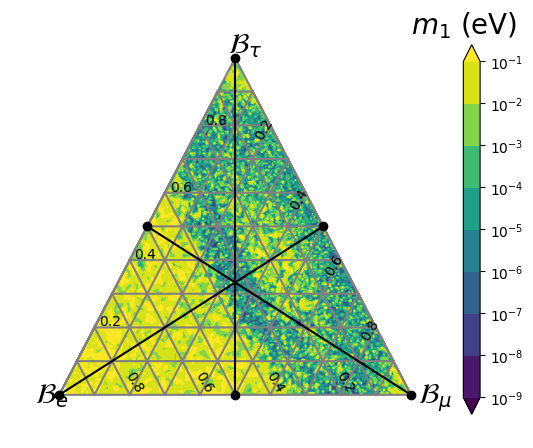

2018-07-17 15:23:24.097416


In [10]:
#def flavorplot(df,IH=False,savepdf=False):
import datetime
if 1==1:
    df=xdp 
    IH=False
    savepdf=False
#    savepdf=True
    if IH==True:
        nui=3
    else:
        nui=1
    
    x=triang_x(df.Y1e**2,df.Y1mu**2,df.Y1tau**2)
    y=triang_y(df.Y1e**2,df.Y1mu**2,df.Y1tau**2)
    z=np.log10(np.abs(df['m_nu_%d' %nui])*1E9)
    logmnu=range(int(round(z.min(),2)),\
                      int(round(z.max(),2)))
    triangleplot(x,y,z,levels=logmnu,scale='log',title=r'$m_%d$ (eV)' %nui,\
                 xlabel=r'$\mathcal{B}_e$',ylabel=r'$\mathcal{B}_\mu$',zlabel=r'$\mathcal{B}_\tau$')
    if savepdf:
        if IH:
            plt.savefig('IH.pdf')
        else:
            plt.savefig('NH.pdf')
    plt.show()
    print datetime.datetime.now()

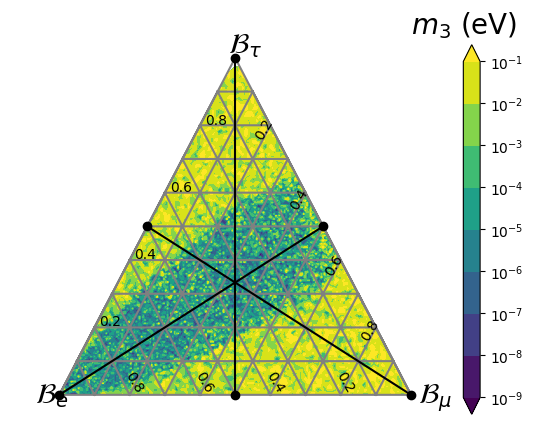

2018-07-17 15:23:28.534314


In [11]:
#def flavorplot(df,IH=False,savepdf=False):
if 1==1:
    df=xip 
    IH=True
    savepdf=False
#    savepdf=True
    if IH==True:
        nui=3
    else:
        nui=1
    
    x=triang_x(df.Y1e**2,df.Y1mu**2,df.Y1tau**2)
    y=triang_y(df.Y1e**2,df.Y1mu**2,df.Y1tau**2)
    z=np.log10(np.abs(df['m_nu_%d' %nui])*1E9)
    logmnu=range(int(round(z.min(),2)),\
                      int(round(z.max(),2)))
    triangleplot(x,y,z,levels=logmnu,scale='log',title=r'$m_%d$ (eV)' %nui,\
                 xlabel=r'$\mathcal{B}_e$',ylabel=r'$\mathcal{B}_\mu$',zlabel=r'$\mathcal{B}_\tau$')
    if savepdf:
        if IH:
            plt.savefig('IH.pdf')
        else:
            plt.savefig('NH.pdf')
    plt.show()
    print datetime.datetime.now()

In [12]:
# %load triangleplot.py
def triangleploty(x,y,z,levels=[],scale='lin',title='',xlabel='',ylabel='',zlabel=''):
    import matplotlib
    import matplotlib.pyplot as plt
    plt.rcdefaults()
    import numpy as np
    import matplotlib.cm as cm
    import matplotlib.mlab as mlab
    import scipy.interpolate

    import matplotlib.cbook as cbook
    import matplotlib.tri as mtri

    # Data to plot triangular grid
    data=np.loadtxt("grid.dat")

    # Create  & plot triangulation.
    triang = mtri.Triangulation(data[:,0], data[:,1])
    plt.triplot(triang, color='0.5')

    #Load the exclusion limits data in the form: BRa BRb BRc limit. 
    #This is in principle the result of running your dedicated code implementing the analysis.



    #Drawing the medians if necessary

    plt.plot([0.5,0.5], [0, 0.866], 'ko-')
    plt.plot([0.25,1], [0.433, 0], 'ko-')
    plt.plot([0,0.75], [0, 0.433], 'ko-')


    #x=(2*b + c)/2
    #y=sqrt(3)*c/2
    
    #plt.hexbin(x,y,np.abs(df.m_nu_1),norm=matplotlib.colors.LogNorm(),gridsize =200)


    #Building the griddata by interpolating between the grid points 
    #plt.title(r'$m_{MIN}$ (eV)',verticalalignment='bottom')
    # just an arbitrary number for grid point
    ngrid = 200

    # you could use x.min()/x.max() for creating xi and y.min()/y.max() for yi
    xi = np.linspace(x.min(),x.max(),ngrid)
    yi = np.linspace(y.min(),y.max(),ngrid)

    # create the grid data for the contour plot
    zi = mlab.griddata(x,y,z,xi,yi, interp='linear')

    CS3 = plt.contourf(xi,yi,zi,levels=levels, extend='both') #,cmap=plt.cm.winter
    #CS3 = plt.contourf(xi,yi,zi,norm=matplotlib.colors.LogNorm() )
    CS3c=plt.colorbar(pad=0.07)
    if scale=='log':
        CS3c.set_ticklabels([ r'$10^{%d}$' %i for i in levels])
    #Vertex Labels
    #plt.text(-0.1,-0.02, r'$g \tilde{\chi}^0_1$ ', fontsize=20)
    #plt.text(1.02,-0.02,r'$ b \bar{b} \tilde{\chi}^0_1$'min_nulight=min_nulight,\
    #plt.text(0.48,0.88,r'$t \bar{t} \tilde{\chi}^0_1$', fontsize=20)
    plt.text(1.,0.93,title, fontsize=20)
    plt.text(-0.08,-0.07, xlabel, fontsize=20)
    plt.text(0.97,-0.07,ylabel, fontsize=20)
    plt.text(0.45,0.89,zlabel, fontsize=20)

    #grid labels
    plt.text(0.114,0.180, '0.2')
    plt.text(0.214,0.3520, '0.4')
    plt.text(0.314, 0.5240, '0.6')
    plt.text(0.414,0.6960, '0.8')
    plt.text(0.85,0.173, '0.8', rotation=60)
    plt.text(0.75,0.34, '0.6', rotation=60)
    plt.text(0.65, 0.51, '0.4', rotation=60)
    plt.text(0.55,0.69, '0.2', rotation=60)
    plt.text(0.18,0.04, '0.8',rotation=-60)
    plt.text(0.38,0.04, '0.6', rotation=-60)
    plt.text(0.58, 0.04, '0.4', rotation=-60)
    plt.text(0.78,0.04, '0.2', rotation=-60)
    plt.ylim(-0.05,0.9)
    plt.axis('off')
    

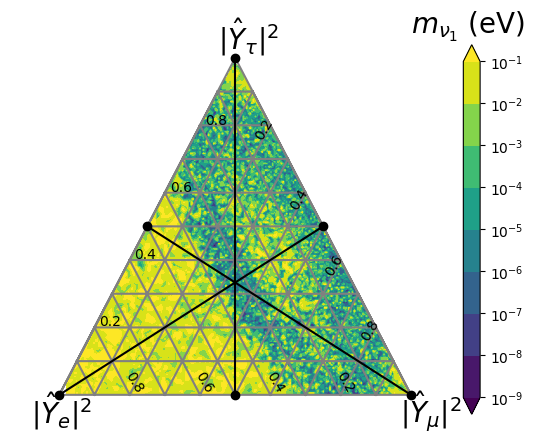

2018-07-17 15:23:39.150209


In [13]:
#def flavorplot(df,IH=False,savepdf=False):
import datetime
if 1==1:
    df=xdp 
    IH=False
    savepdf=False
#    savepdf=True
    if IH==True:
        nui=3
    else:
        nui=1
    
    x=triang_x(df.Y1e**2,df.Y1mu**2,df.Y1tau**2)
    y=triang_y(df.Y1e**2,df.Y1mu**2,df.Y1tau**2)
    z=np.log10(np.abs(df['m_nu_%d' %nui])*1E9)
    logmnu=range(int(round(z.min(),2)),\
                      int(round(z.max(),2)))
    triangleploty(x,y,z,levels=logmnu,scale='log',title=r'$m_{\nu_%d}$ (eV)' %nui,\
                 xlabel=r'$|\hat{Y}_e|^2$',ylabel=r'$|\hat{Y}_\mu|^2$',zlabel=r'$|\hat{Y}_\tau|^2$')
    if savepdf:
        if IH:
            plt.savefig('IHY.pdf')
        else:
            plt.savefig('NHY.pdf')
    plt.show()
    print datetime.datetime.now()

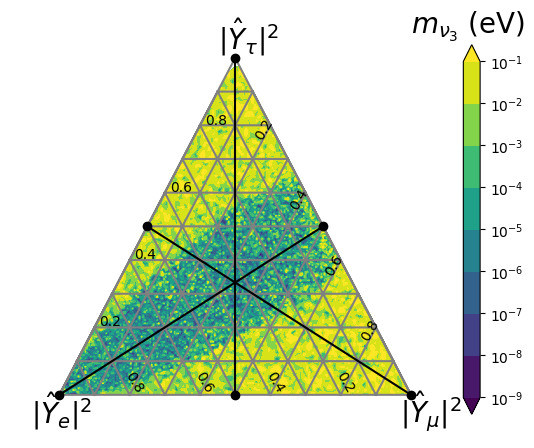

2018-07-17 15:23:45.256909


In [14]:
#def flavorplot(df,IH=False,savepdf=False):
if 1==1:
    df=xip 
    IH=True
#    savepdf=False
    savepdf=True
    if IH==True:
        nui=3
    else:
        nui=1
    
    x=triang_x(df.Y1e**2,df.Y1mu**2,df.Y1tau**2)
    y=triang_y(df.Y1e**2,df.Y1mu**2,df.Y1tau**2)
    z=np.log10(np.abs(df['m_nu_%d' %nui])*1E9)
    logmnu=range(int(round(z.min(),2)),\
                      int(round(z.max(),2)))
    triangleploty(x,y,z,levels=logmnu,scale='log',title=r'$m_{\nu_%d}$ (eV)' %nui,\
                 xlabel=r'$|\hat{Y}_e|^2$',ylabel=r'$|\hat{Y}_\mu|^2$',zlabel=r'$|\hat{Y}_\tau|^2$')
    if savepdf:
        if IH:
            plt.savefig('IHY.pdf')
        else:
            plt.savefig('NHY.pdf')
    plt.show()
    print datetime.datetime.now()